# Dynamic World LULC Pipeline
The dynamic world land cover dataset is available through Google Earth Engine. 

[Dynamic World V1](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1#terms-of-use)

[Introduction to Dynamic World Tutorials](https://developers.google.com/earth-engine/tutorials/community/introduction-to-dynamic-world-pt-1)

[Earth Engine Access](https://developers.google.com/earth-engine/guides/access)

## Imports

In [4]:
# General imports:
import numpy as np
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs 
import os
import yaml

# Google Earth Engine imports:
import ee
import geemap
from google.auth import default
import certifi
import ssl

Prior to running the code below, I created an ee project. In this case, I initialized a free, non-commercial use project. This will need to be addressed as we move forward. The project was created in earth engine, and then the project ID and credentials were established by running the following line in terminal: 

`earthengine authenticate`

This will open a browser window to login to the appropriate Google account. In the case you are already logged into another account, run the following code to reset:

In [ ]:
# import os
# import shutil

# ee_credentials_path = os.path.expanduser("~/.config/earthengine/credentials")

# if os.path.exists(ee_credentials_path): 
#     shutil.rmtree(os.path.dirname(ee_credentials_path)) 
#     print("Existing Earth Engine credentials removed.") 
# else: 
#     print("No existing Earth Engine credentials found.")

Then if you are using a Mac, you may need to follow the instructions here to install your certificate: https://stackoverflow.com/questions/68275857/urllib-error-urlerror-urlopen-error-ssl-certificate-verify-failed-certifica

Following that, restart the kernel and continue:

In [3]:
# Create a context using the certifi bundle.
context = ssl.create_default_context(cafile=certifi.where())

# Run the following code to authenticate. You will be sent to retrieve an API token.
ee.Authenticate()

# Initialize earth engine and geemap, replacing the project name below with your project name.
ee.Initialize(opt_url="https://earthengine.googleapis.com", project="dynamic-world-pipeline")
geemap.ee_initialize()


In [16]:

def get_boundaries(path):
    """Given path to geojson, return AOI as an ee Geometry object."""

    # Load the geojson.
    aoi_file = gpd.read_file(path)
    
    # Convert the GeoPandas geometry to GeoJSON.
    aoi_geom = aoi_file.iloc[0].geometry.__geo_interface__
    
    # Convert to an ee Geometry object.
    ee_polygon = ee.Geometry(aoi_geom)
        
    return(ee_polygon)

def get_bbox(path):
    """Given path to geojson, return AOI bounding box."""

    # Load the geojson.
    aoi_file = gpd.read_file(path)

    # Calculate the bounding box [minx, miny, maxx, maxy].
    bounds = aoi_file.total_bounds 
    
    # Create an ee.Geometry object from the bounding box.
    aoi = ee.Geometry.Rectangle([bounds[0], bounds[1], bounds[2], bounds[3]])
    
    return(aoi)

def fetch_dynamic_world(aoi_path, date, date_buffer, out_dir):
    """
    Function to acquire Dynamic World raster for a specific polygon and date range.
    
    Inputs:
    aoi         : ee.Geometry.Polygon defining the area of interest
    date        : specific date to aim for (YYYY-MM-DD)
    date_buffer : number of days to buffer date parameter with on either side
                  (e.g. start_date = date - date_buffer & 
                   end_date = date + date_buffer)
    
    Outputs:
    xr_ds : xarray Dataset containing the Dynamic World data composited over time period.
    """
    # Use date_buffer to set the start and end date surrounding date of interest.
    start_date = ee.Date(date).advance(-date_buffer, 'day')
    end_date = ee.Date(date).advance(date_buffer, 'day')
    
    # Get aoi bounding box polygon.
    aoi = get_bbox(aoi_path)
    
    # Load the Dynamic World image collection for the aoi and dates of interest.
    imcol = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
             .filterBounds(aoi)
             .filterDate(start_date, end_date)
             .select('label') # 'Label' contains the band index of highest probability land cover class for each pixel.
            )

    # Get the list of dates in the collection
    dates = imcol.aggregate_array('system:time_start').getInfo()
    dates = [np.datetime64(ee.Date(date).format('YYYY-MM-dd').getInfo()) for date in dates]
    print(f'Dynamic World Data Dates: {dates}')

    # Reduce to the most probable land cover type across time period.
    dw_composite = imcol.reduce(ee.Reducer.mode())

    # Convert ee.Date to human-readable strings
    start_date_str = start_date.format('YYYYMMdd').getInfo() 
    end_date_str = end_date.format('YYYYMMdd').getInfo()

    # Construct output file path.
    out_path = os.path.join(out_dir, f'dynamic_world_{start_date_str}_{end_date_str}.tif')
    
    # Export the dynamic world data as a GeoTIFF.
    geemap.ee_export_image(dw_composite, filename = out_path, scale = 10, region = aoi)
    print(f"Exported dynamic world composite to {out_path}")
    
    return out_path

In [48]:
# Set target date of interest.
date = '2021-06-01'
date_buffer = 16

# Read config information from yml file.
with open("config.yml", "r") as yml:
    config = yaml.safe_load(yml)

out_dir = config['out-dir']
aoi_path = config['aoi-path']

# Call function to export dynamic world raster.
dynamic_world_tif = fetch_dynamic_world(aoi_path, date, date_buffer, out_dir)

Dynamic World Data Dates: [np.datetime64('2021-05-19'), np.datetime64('2021-06-13')]
Generating URL ...
Please wait ...
Data downloaded to /Users/snix/Documents/2024/Cecil/CodeRepos/dynamic-world-pipeline/outputs/dynamic_world_20210516_20210617.tif
Exported dynamic world composite to outputs/dynamic_world_20210516_20210617.tif


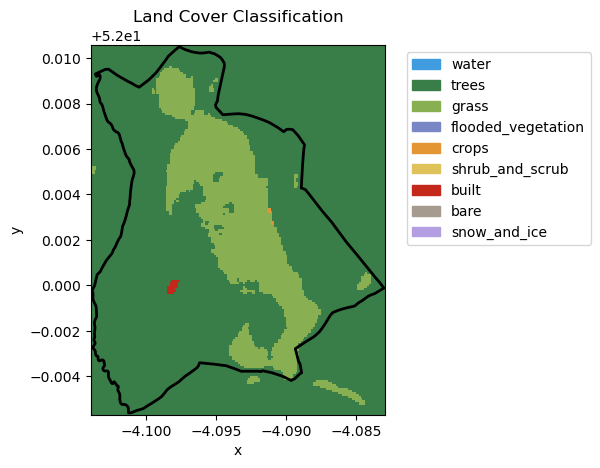

In [49]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the color palette, labels, and corresponding values.
colors = ['#419bdf', '#397d49', '#88b053', '#7a87c6', '#e49635', '#dfc35a', '#c4281b', '#a59b8f', '#B39FE1']  
labels = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
values = [0, 1, 2, 3, 4, 5, 6, 7, 8] 

# Create a colormap and a normalization based on the values.
cmap = ListedColormap(colors)
norm = BoundaryNorm(values + [max(values) + 1], cmap.N)  # Ensures correct mapping of values to colors

# Open the GeoTIFF using rioxarray.
classification = rxr.open_rasterio(dynamic_world_tif)

# Plot the dynamic world composite raster.
plt.figure()
img = classification.plot(cmap=cmap, norm=norm, add_colorbar=False)
img.axes.set_aspect('equal')

# Read the AOI geojson as geodataframe.
aoi_gdf = gpd.read_file(aoi_path)
aoi_gdf.boundary.plot(ax=img.axes, edgecolor='black', linewidth=2)

# Create a custom legend.
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot.
plt.title('Land Cover Classification')
plt.show()
